<a href="https://colab.research.google.com/github/chamisfum/Brain_Tumor_Classification_Trial/blob/master/Model_Percobaan_MNv2HypeTune_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import numpy as np
import os
import shutil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
os.environ['CONFIG_DIR'] = "/content/drive/My Drive/RESEARCH CENTER/DATASETS/BRAIN_TUMOR/dataset"

In [ ]:
%cd /content/drive/My Drive/RESEARCH CENTER/DATASETS/BRAIN_TUMOR/dataset

/content/drive/My Drive/RESEARCH CENTER/DATASETS/BRAIN_TUMOR/dataset


In [ ]:
ls

AUGMENTATION/                draft/      readme.txt
AUGMENTATION_USUYAMA_CLAHE/  IMBALANCE/  save_model/
BALANCE/                     percobaan/  SPLIT_AUGMENTATION/


In [ ]:
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

In [ ]:
path_train = 'percobaan/train/'
path_val = 'percobaan/val/'
path_test = 'percobaan/test/'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
                            #  rotation_range=40,
                            #  width_shift_range=0.2,
                            #  height_shift_range=0.2,
                            #  shear_range=0.2,
                            #  zoom_range=0.2,
                            #  horizontal_flip=True,
                             fill_mode='nearest')

training_set = datagen.flow_from_directory(path_train,
                                           target_size=(128,128),
                                           color_mode="rgb",
                                           shuffle=False,
                                           batch_size = 64,
                                           class_mode='categorical')

validation_set = datagen.flow_from_directory(path_val,
                                             target_size=(128,128),
                                             color_mode="rgb",
                                             shuffle=False,
                                             batch_size = 64,
                                             class_mode='categorical')

testing_set = datagen.flow_from_directory(path_test,
                                          target_size=(128,128),
                                          color_mode="rgb",
                                          shuffle=False,
                                          batch_size = 64,
                                          class_mode='categorical')

Found 12256 images belonging to 3 classes.
Found 2297 images belonging to 3 classes.
Found 767 images belonging to 3 classes.


In [ ]:
from tensorboard.plugins.hparams import api as hp
import datetime

In [ ]:
%load_ext tensorboard

In [ ]:
HP_FIRST_UNITS = hp.HParam('first_units', hp.Discrete([1024, 512]))
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([512, 256, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'adadelta', 
                                                   'rmsprop', 'adamax', 'nadam']))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.001, 0.0005, 0.0001]))

METRIC_ACCURACY = 'accuracy'

In [ ]:
ls

AUGMENTATION/                draft/      readme.txt
AUGMENTATION_USUYAMA_CLAHE/  IMBALANCE/  save_model/
BALANCE/                     percobaan/  SPLIT_AUGMENTATION/


In [ ]:
with tf.summary.create_file_writer('save_model/logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
filepath="/content/drive/My Drive/RESEARCH CENTER/DATASETS/BRAIN_TUMOR/dataset/save_model/temp_trial/{epoch:03d}-val_acc:{val_acc:.3f}.h5"
checkpoint = callbacks.ModelCheckpoint(
                                       filepath,
                                       monitor='val_acc',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='auto',
                                      #  restore_best_weights=True,
                                       )
earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                    mode='auto',
                                    patience=4,
                                    restore_best_weights=True)

In [ ]:
train_step_size = training_set.n//training_set.batch_size
val_step_size = validation_set.n//validation_set.batch_size

In [ ]:
def train_test_model(hparams):
    model = Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(hparams[HP_FIRST_UNITS], activation = 'relu'))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation = 'relu'))
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation = 'relu'))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    model.add(layers.Dense(3, activation = 'softmax'))
    model.layers[0].trainable = False
    model.summary()

    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = optimizers.SGD(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "adadelta":
        optimizer = optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer=='adamax':
        optimizer = optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer=='nadam':
        optimizer = optimizers.Nadam(learning_rate=learning_rate)

    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))

    # Comiple the mode with the optimizer and learninf rate specified in hparams
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

    history = model.fit(training_set, 
                        steps_per_epoch=train_step_size, 
                        epochs=10,
                        validation_data=validation_set, 
                        validation_steps=val_step_size, 
                        callbacks=[tf.keras.callbacks.TensorBoard(log_dir),  # log metrics
                                   hp.KerasCallback(log_dir, hparams), 
                                   checkpoint]
                        )
    return history.history['val_acc'][-1]

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=50)

In [ ]:
base_model = applications.MobileNetV2(include_top=False,weights='imagenet',input_shape=(128,128,3))
base_model.summary()

In [ ]:
session_num = 0
for first_units in HP_FIRST_UNITS.domain.values:
  for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
      for optimizer in HP_OPTIMIZER.domain.values:
          for learning_rate in HP_LEARNING_RATE.domain.values:
            hparams = {
                HP_FIRST_UNITS: first_units,
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
                HP_LEARNING_RATE: learning_rate,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('save_model/logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

In [ ]:
%%bash
wget -q 'https://storage.googleapis.com/download.tensorflow.org/tensorboard/hparams_demo_logs.zip'
unzip -q hparams_demo_logs.zip -d save_model/logs/hparam_demo

In [ ]:
%tensorboard --logdir save_model/logs/hparam_demo

# **Build Model**

In [ ]:
base_model = applications.MobileNetV2(include_top=False,weights='imagenet',input_shape=(128,128,3))
base_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128    

In [ ]:
model2 = Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(1028, activation = 'elu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation = 'elu'))
model2.add(layers.Dense(256, activation = 'elu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(3, activation = 'softmax'))
model2.layers[0].trainable = False
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1028)              21054468  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               526848    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [ ]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adadelta(lr=1e-4),
              metrics = ['acc'])

In [ ]:
filepath="D:/CHAMDANI/RESEARCH CENTER/BRAIN_TUMOR/save_model/temp/{epoch:03d}-val_acc:{val_acc:.3f} .h5"
checkpoint = callbacks.ModelCheckpoint(
                                       filepath,
                                       monitor='val_acc',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='auto',
                                      #  restore_best_weights=True,
                                       )
earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                    mode='auto',
                                    patience=4,
                                    restore_best_weights=True)

In [ ]:
train_step_size = training_set.n//training_set.batch_size
val_step_size = validation_set.n//validation_set.batch_size

In [ ]:
history = model2.fit(training_set, 
                    steps_per_epoch=train_step_size, 
                    epochs=20,
                    validation_data=validation_set, 
                    validation_steps=val_step_size, 
                    callbacks=[checkpoint])

## **eval**

In [ ]:
model.evaluate(training_set)

192/192 [==============================] - 29s 150ms/step - loss: 0.2197 - acc: 0.9168


[0.21971838176250458, 0.9167754650115967]

In [ ]:
model.evaluate(validation_set)

36/36 [==============================] - 5s 149ms/step - loss: 0.2736 - acc: 0.8838


[0.2736424505710602, 0.8837614059448242]

In [ ]:
model.evaluate(testing_set)

12/12 [==============================] - 2s 154ms/step - loss: 0.2774 - acc: 0.8892


[0.27741801738739014, 0.8891786336898804]

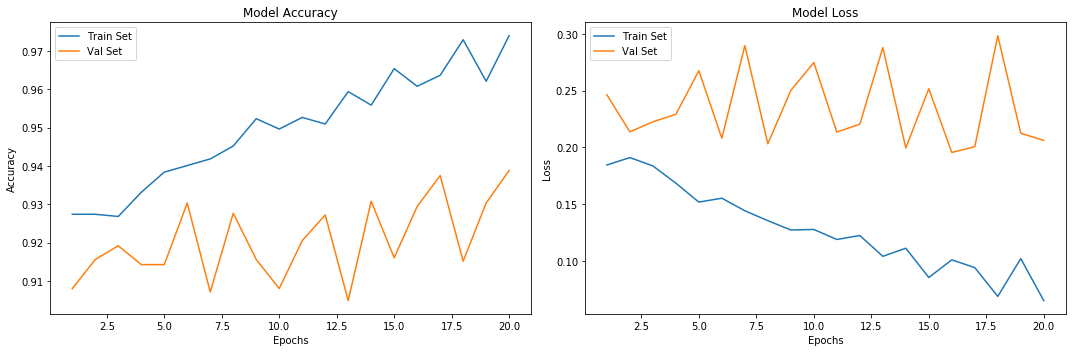

In [ ]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# **Evaluasi Model**

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
xtr, ytr = zip(*(training_set[i] for i in range(len(training_set))))
x_train, y_train = np.vstack(xtr), np.vstack(ytr)

In [ ]:
xvl, yvl = zip(*(validation_set[i] for i in range(len(validation_set))))
x_val, y_val = np.vstack(xvl), np.vstack(yvl)

In [ ]:
xts, yts = zip(*(testing_set[i] for i in range(len(testing_set))))
x_test, y_test = np.vstack(xts), np.vstack(yts)

In [ ]:
# Found 12256 images belonging to 3 classes.
# Found 2297 images belonging to 3 classes.
# Found 767 images belonging to 3 classes.
num_of_train_samples = 12256  
num_of_val_samples = 2297  
num_of_test_samples = 767
batch_size = 64

In [ ]:
y_true_test = testing_set.classes
Y_pred_test = model.predict(testing_set, num_of_test_samples // batch_size+1)
y_pred_test = np.argmax(Y_pred_test, axis=1)

y_true_train = training_set.classes
Y_pred_train = model.predict(training_set, num_of_train_samples // batch_size+1)
y_pred_train = np.argmax(Y_pred_train, axis=1)

y_true_val = validation_set.classes
Y_pred_val = model.predict(validation_set, num_of_val_samples // batch_size+1)
y_pred_val = np.argmax(Y_pred_val, axis=1)

In [ ]:
train_loss, train_acc = model.evaluate(x_train, y_train)
val_loss, val_acc = model.evaluate(x_val, y_val)
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Train accuracy:', train_acc)
print('Train loss:', train_loss)
print('Val accuracy:', val_acc)
print('Val loss:', val_loss)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

24/24 [==============================] - 1s 43ms/step - loss: 0.3577 - acc: 0.9387
Train accuracy: 1.0
Train loss: 6.435615773625614e-07
Val accuracy: 0.9512407779693604
Val loss: 0.32882943749427795
Test accuracy: 0.9387223124504089
Test loss: 0.3576686680316925


In [ ]:
print("Precision Score Train Data : ",precision_score(y_true_train, y_pred_train, average='weighted'))
print("Precision Score Val Data   : ",precision_score(y_true_val, y_pred_val, average='weighted'))
print("Precision Score Test Data  : ",precision_score(y_true_test, y_pred_test, average='weighted'))

Precision Score Train Data :  1.0
Precision Score Val Data   :  0.9508264496474654
Precision Score Test Data  :  0.9379120475955713


In [ ]:
print("Recall Score Train Data : ",recall_score(y_true_train, y_pred_train, average='weighted'))
print("Recall Score Val Data   : ",recall_score(y_true_val, y_pred_val, average='weighted'))
print("Recall Score Test Data  : ",recall_score(y_true_test, y_pred_test, average='weighted'))

Recall Score Train Data :  1.0
Recall Score Val Data   :  0.9512407488027862
Recall Score Test Data  :  0.9387222946544981


In [ ]:
print('Classification Report Train Data')
print(classification_report(y_true_train, y_pred_train, target_names=training_set.class_indices))

Classification Report Train Data
              precision    recall  f1-score   support

      GLIOMA       1.00      1.00      1.00      5704
  MENINGIOMA       1.00      1.00      1.00      2832
   PITUITARY       1.00      1.00      1.00      3720

    accuracy                           1.00     12256
   macro avg       1.00      1.00      1.00     12256
weighted avg       1.00      1.00      1.00     12256



In [ ]:
print('Classification Report Val Data')
print(classification_report(y_true_val, y_pred_val, target_names=validation_set.class_indices))

Classification Report Val Data
              precision    recall  f1-score   support

      GLIOMA       0.96      0.96      0.96      1069
  MENINGIOMA       0.91      0.88      0.90       531
   PITUITARY       0.97      0.99      0.98       697

    accuracy                           0.95      2297
   macro avg       0.95      0.94      0.95      2297
weighted avg       0.95      0.95      0.95      2297



In [ ]:
print('Classification Report Test Data')
print(classification_report(y_true_test, y_pred_test, target_names=testing_set.class_indices))

Classification Report Test Data
              precision    recall  f1-score   support

      GLIOMA       0.95      0.95      0.95       357
  MENINGIOMA       0.90      0.84      0.87       177
   PITUITARY       0.95      1.00      0.97       233

    accuracy                           0.94       767
   macro avg       0.93      0.93      0.93       767
weighted avg       0.94      0.94      0.94       767



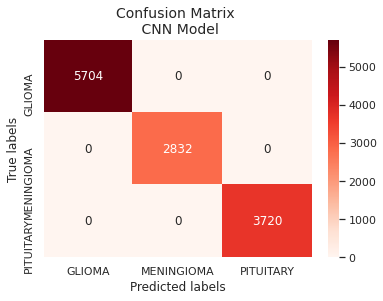

In [ ]:
Cmatrix = metrics.confusion_matrix(y_true_train, y_pred_train)
class_names = training_set.class_indices

ax= plt.subplot()
sns.heatmap(Cmatrix,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix \n CNN Model',fontsize=14)
plt.show()

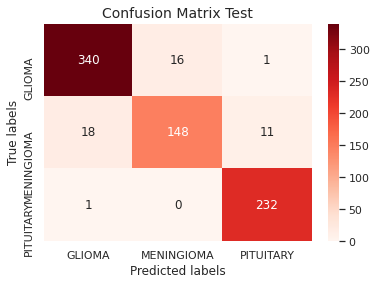

In [ ]:
Cmatrix_test = metrics.confusion_matrix(y_true_test, y_pred_test)
class_names = training_set.class_indices

ax= plt.subplot()
sns.heatmap(Cmatrix_test,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

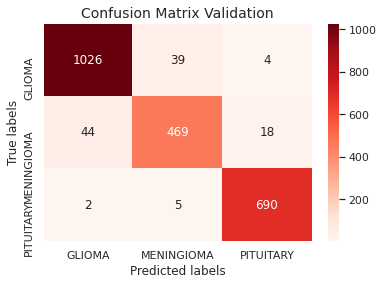

In [ ]:
Cmatrix_val = metrics.confusion_matrix(y_true_val, y_pred_val)
class_names = training_set.class_indices

ax= plt.subplot()
sns.heatmap(Cmatrix_val,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Validation',fontsize=14)
plt.show()

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import  precision_recall_curve, balanced_accuracy_score, auc

In [ ]:
print('Accuracy Score Train Data :', accuracy_score(y_true_train, y_pred_train))
print('Accuracy Score Val Data   :', accuracy_score(y_true_val, y_pred_val))
print('Accuracy Score Test Data  :', accuracy_score(y_true_test, y_pred_test))

Accuracy Score Train Data : 1.0
Accuracy Score Val Data   : 0.9512407488027862
Accuracy Score Test Data  : 0.9387222946544981


In [ ]:
print('Balanced accuracy Score Train Data :', balanced_accuracy_score(y_true_train, y_pred_train))
print('Balanced accuracy Score Val Data   :', balanced_accuracy_score(y_true_val, y_pred_val))
print('Balanced accuracy Score Test Data  :', balanced_accuracy_score(y_true_test, y_pred_test))

Balanced accuracy Score Train Data : 1.0
Balanced accuracy Score Val Data   : 0.9443238736270226
Balanced accuracy Score Test Data  : 0.9280824329925953


In [ ]:
cm = metrics.confusion_matrix(y_true_train, y_pred_train)
sensi = cm[0][0] / (cm[0][0] + (cm[0][1]+cm[0][2]))
speci = cm[0][0] / (cm[0][0] + (cm[1][0]+cm[2][0]))

print('Sensitivity Score Train Data :', sensi)
print('Specificity Score Train Data :', speci)

cm = metrics.confusion_matrix(y_true_val, y_pred_val)
sensi = cm[0][0] / (cm[0][0] + (cm[0][1]+cm[0][2]))
speci = cm[0][0] / (cm[0][0] + (cm[1][0]+cm[2][0]))

print('Sensitivity Score Val Data :', sensi)
print('Specificity Score Val Data :', speci)

cm = metrics.confusion_matrix(y_true_test, y_pred_test)
sensi = cm[0][0] / (cm[0][0] + (cm[0][1]+cm[0][2]))
speci = cm[0][0] / (cm[0][0] + (cm[1][0]+cm[2][0]))

print('Sensitivity Score Test Data :', sensi)
print('Specificity Score Test Data :', speci)

Sensitivity Score Train Data : 1.0
Specificity Score Train Data : 1.0
Sensitivity Score Val Data : 0.9597754911131899
Specificity Score Val Data : 0.957089552238806
Sensitivity Score Test Data : 0.9523809523809523
Specificity Score Test Data : 0.947075208913649


In [ ]:
print('Precision Score Train Data :', precision_score(y_true_train, y_pred_train, average='weighted'))
print('Precision Score Val Data   :', precision_score(y_true_val, y_pred_val, average='weighted'))
print('Precision Score Test Data  :', precision_score(y_true_test, y_pred_test, average='weighted'))

Precision Score Train Data : 1.0
Precision Score Val Data   : 0.9508264496474654
Precision Score Test Data  : 0.9379120475955713


In [ ]:
print('Recall Score Train Data :', recall_score(y_true_train, y_pred_train, average='weighted'))
print('Recall Score Val Data   :', recall_score(y_true_val, y_pred_val, average='weighted'))
print('Recall Score Test Data  :', recall_score(y_true_test, y_pred_test, average='weighted'))

Recall Score Train Data : 1.0
Recall Score Val Data   : 0.9512407488027862
Recall Score Test Data  : 0.9387222946544981


In [ ]:
print('F1 Score Train Data :', f1_score(y_true_train, y_pred_train, average='weighted'))
print('F1 Score Val Data   :', f1_score(y_true_val, y_pred_val, average='weighted'))
print('F1 Score Test Data  :', f1_score(y_true_test, y_pred_test, average='weighted'))

F1 Score Train Data : 1.0
F1 Score Val Data   : 0.9509372772026333
F1 Score Test Data  : 0.9378649325251746


In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(3):
#     fpr[i], tpr[i], _ = roc_curve(y_true_test[:, i], y_pred_test[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# precision_train, recall_train, _ = precision_recall_curve(y_true_train, y_pred_train)
# precision_val, recall_val, _ = precision_recall_curve(y_true_val, y_pred_val)
# precision_test, recall_test, _ = precision_recall_curve(y_true_test, y_pred_test)

# print('AUC Score Train Data :', auc(precision_train, recall_train))
# print('AUC Score Val Data   :', auc(precision_val, recall_val))
# print('AUC Score Test Data  :', auc(precision_test, recall_test))

# **Prediction**

In [ ]:
predict_set = datagen.flow_from_directory('percobaan/tebak',
                                           target_size=(128,128),
                                           color_mode="rgb",
                                           shuffle=False,
                                           batch_size = 64,
                                           class_mode='categorical')

Found 25 images belonging to 1 classes.


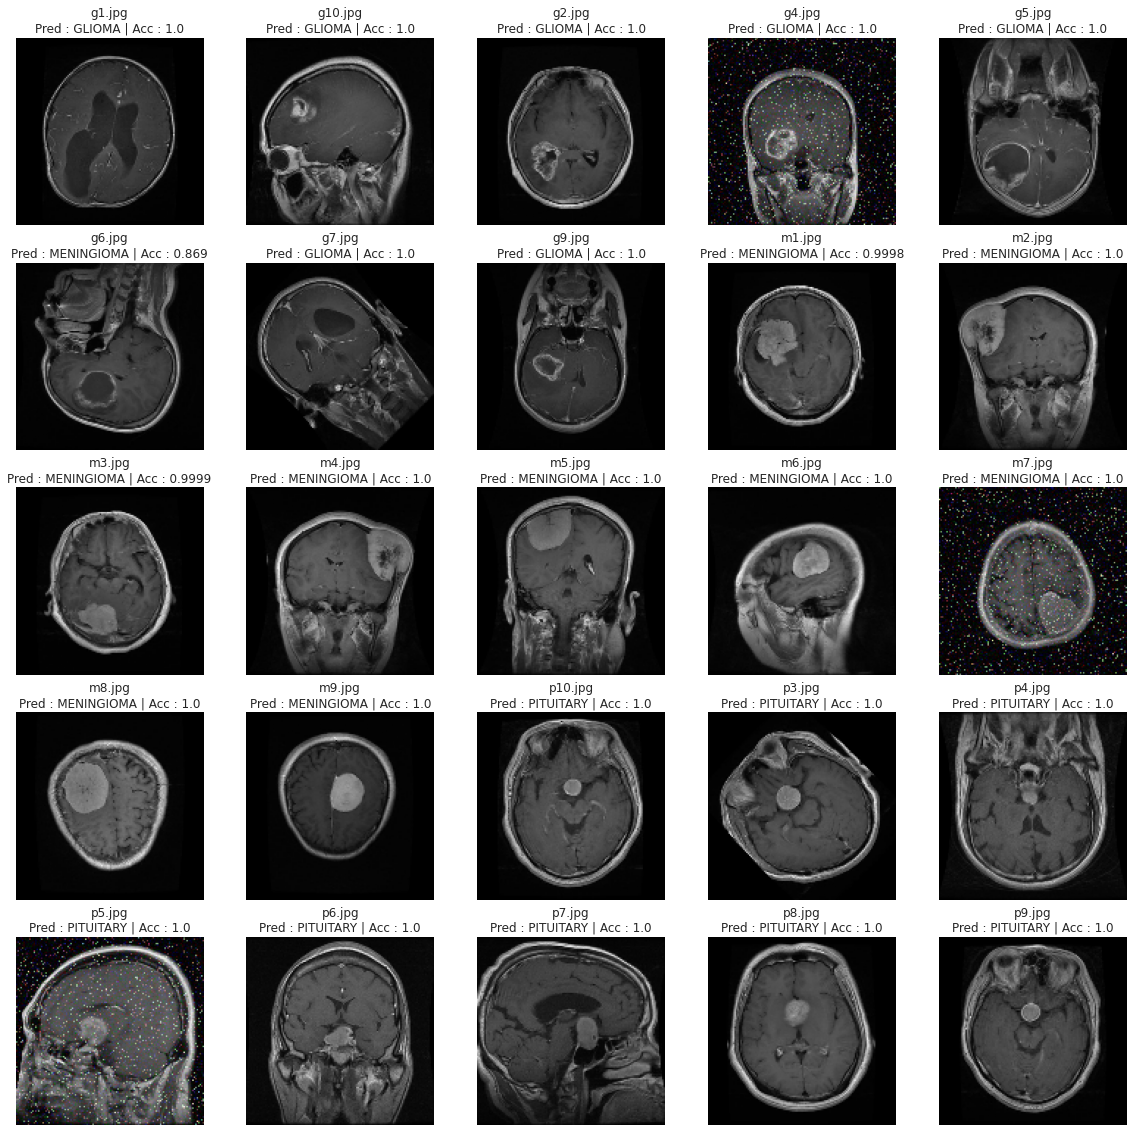

In [ ]:
from tensorflow.keras.preprocessing import image

fig, ax = plt.subplots(5, 5, figsize = (20, 20))
for f in range(0,25):
  fl = 'percobaan/tebak/'+predict_set.filenames[f]
  img = image.load_img(fl, target_size=(128,128,3))
  img = image.img_to_array(img)
  img = img/255

  classes = list(testing_set.class_indices.keys())
  proba = model.predict(img.reshape(1,128,128,3))
  top_3 = np.argsort(proba[0])
  for i in range(3):
      ax[f//5, f%5].imshow(img)
      ax[f//5, f%5].axis('off')
      ax[f//5, f%5].set_title(predict_set.filenames[f].split('/')[1]+"\nPred : {}".format(classes[top_3[i]])+" | Acc : {:.4}".format(proba[0][top_3[i]]))

In [ ]:
# from tensorflow.keras.preprocessing import image

# fl = 'percobaan/test/'+testing_set.filenames[i]

# img = image.load_img(fl, target_size=(128,128,3))
# img = image.img_to_array(img)
# img = img/255

# classes = list(testing_set.class_indices.keys())
# proba = model.predict(img.reshape(1,128,128,3))
# top_3 = np.argsort(proba[0])[:-4:-1]
# for i in range(3):
#     print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
# plt.imshow(img)

In [ ]:
# model.save('trial_model_v8.h5') 
# model.save_weights("trial_weights_v8.h5")